
# Family food in UK shopping carts

- _Author_: Lucas Gonzalez Santa Cruz
- _Workshop_: Data Science Intensive, http://www.springboard.com
- _Date_: 6 October 2016.

# Table of Contents
* [1. Motivation and goals](#1.-Motivation-and-goals)
* [2. Data source and datasets](#2.-Data-source-and-datasets)
* [3. Data wrangling and exploratory data analysis](#3.-Data-wrangling-and-exploratory-data-analysis)
    * [3.1. Files and initial settings](#3.1.-Files-and-initial-settings)
    * [3.2. Families](#3.2.-Families)
        * [3.2.a. Initial set of variables](#3.2.a.-Initial-set-of-variables)
        * [3.2.b. Auxiliary literals](#3.2.b.-Auxiliary-literals)
        * [3.2.c. Exploratory data analysis of families](#3.2.c.-Exploratory-data-analysis-of-families)
    * [3.3. Food](#3.3.-Food)
        * [3.3.a. Food items, groups and units](#3.3.a.-Food-items,-groups-and-units)
        * [3.3.b. Weekly purchases](#3.3.b.-Weekly-purchases)
        * [3.3.c. Weekly purchases per family](#3.3.c.-Weekly-purchases-per-family)
* [4. Data preparation for modeling](#4.-Data-preparation-for-modeling)
    * [4.1. Food-groups: good and bad](#4.1.-Food-groups:-good-and-bad)
    * [4.2. Score: number of times each kind of food was bought](#4.2.-Score:-number-of-times-each-kind-of-food-was-bought)
    * [4.3. Categories: "good cart" vs "bad cart"](#4.3.-Categories:-"good-cart"-vs-"bad-cart")
* [5. Modeling](#5.-Modeling)
    * [5.1. Preliminary exploration](#5.1.-Preliminary-exploration)
        * [5.1.a. Numerical](#5.1.a.-Numerical)
        * [5.1.b. Graphical](#5.1.b.-Graphical)
    * [5.2. Model](#5.2.-Model)
        * [5.2.a. Prepare matrices](#5.2.a.-Prepare-matrices)
        * [5.2.b. LR with whole dataset](#5.2.b.-LR-with-whole-dataset)
        * [5.2.c. Coefficients and Odds Ratios](#5.2.c.-Coefficients-and-Odds-Ratios)
        * [5.2.d Feature reduction with RFE](#5.2.d.-Feature-reduction-with-RFE)
    * [5.3. Model evaluation](#5.3.-Model-evaluation)
        * [5.3.a. Training and test](#5.3.a.-Training-and-test)
        * [5.3.b. Cross-validation](#5.3.b.-Cross-validation)
* [6. Summary and discussion](#6.-Summary-and-discussion)
    * [6.1. Work done](#6.1.-Work-done)
    * [6.2. Limitations](#6.2.-Limitations)
    * [6.3. Main findings and recommendations](#6.3.-Main-findings-and-recommendations)
    * [6.4. What next](#6.4.-What-next)

# 1. Motivation and goals

Food is a vast area, interesting for many inter-related reasons:
- Food security: both for individuals and for groups (poverty), and for the world as a whole (climate change and other reasons for possible supply chain disruption).
- Nutritional health and longevity. As an example, the concept of "blue zones" (places with a high proportion of centenaries) has been correlated to local and seasonal food.
- Ecological reasons: the possibility of growing edible forests using permacultural/agroforestry design, and in particular, making use of experience gained in other places with the notion of "climate analogues".
- Economic developement, as growing food locally means more jobs, or not needing a job.
- Data and automation. It's interesting to see how using satellite data, or drone data, can assist agricultural production by providing different types of images of the fields across time.
- Scenario creation: when we consider the possibility of many people becoming fully vegetarians, or at least more people eating less meat, what would that look like? Would it achieve any measurable goals? Would it even be possible?

The **client** would be a (hypothetical) public health branch of the UK government.

The **goal** for this particular project would be specifically about looking at one particular dataset with the intention of **exploring how food is bought by families in the UK**, in order to look at **which factors predict a good shopping behaviour in terms of food purchase**.

The client would use this information as a small part of their wider guidance in policies for education, promotion of certain foods, etc.

This exploration would also allow to make explicit some deeper questions in other areas:
- What questions can't be answered with this data?
- What would we need to look at in terms of food production?
- Is it possible to imagine matching production and consumption under different scenarios? For example: one with intense and sudden supply disruption such as a severe pandemic, and another in which a substantial proportion of the population want to eat less meat for health and climate-change reasons.

# 2. Data source and datasets

UK families (a different sample each year for many years), have been asked the details about what food they buy for a week.

Data since 2001 is published only in summarised form, not suitable for the kind of analysis needed.

Data between 1974-2000 is open data, and we will be using the data of the 6-year period between 1995 and 2000:
* Available at http://britains-diet.labs.theodi.org
* Datasets:
    * Households: a file with a line per household, and for each of them 53 variables: number of female adults, male adults and children; income; location; etc. Also, many files translating codes to literals: 11=Scotland, 1=household owner is female, etc.
    * Purchases: a file with a line per food item bought: a certain household bought, over the course of a week, 6 loaves of brown bread (money paid), 3 pints of skimmed milk (money paid), etc.
    * Food groups: several files that put the 300+ food items ("milk", "cheese") into 20+ food groups ("milky products").
    * Nutrients: for each food item (and even for 4 "seasons" each year) there's information about 47 nutrients (calories, vitamin D, etc).

**NOTE:** Throughout this report, "households" and "families" are used interchangeably.

# 3. Data wrangling and exploratory data analysis

## 3.1. Files and initial settings

The "food purchase" files were downloaded from the website unzipped into one folder per year, and then placed in one folder for convenience. The "reference" files were placed in another directory.

- http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_2000.zip (same for years 1995-1999)
- http://data.defra.gov.uk/Food/NationalFoodSurvey/NFSopen_Reference.zip

In [1]:
data = 'data/'
dataRefe = 'data/NFSopen_Reference/'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import numpy as np
import scipy as sp

from patsy import dmatrices

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

## 3.2. Families

This is the information about ~7000 households per year, for the period 1995-2000.

In [3]:
df_hous1995 = pd.DataFrame.from_csv(data+'1995 household data.txt', sep='\t', index_col=None)
df_hous1996 = pd.DataFrame.from_csv(data+'1996 household data.txt', sep='\t', index_col=None)
df_hous1997 = pd.DataFrame.from_csv(data+'1997 household data.txt', sep='\t', index_col=None)
df_hous1998 = pd.DataFrame.from_csv(data+'1998 household data.txt', sep='\t', index_col=None)
df_hous1999 = pd.DataFrame.from_csv(data+'1999 household data.txt', sep='\t', index_col=None)
df_hous2000 = pd.DataFrame.from_csv(data+'2000 household data.txt', sep='\t', index_col=None)

df_hous1995['survyear'] = '1995'
df_hous1996['survyear'] = '1996'
df_hous1997['survyear'] = '1997'
df_hous1998['survyear'] = '1998'
df_hous1999['survyear'] = '1999'
df_hous2000['survyear'] = '2000'

list_of_years = [df_hous1995, df_hous1996, df_hous1997, df_hous1998, df_hous1999, df_hous2000]
df = pd.concat(list_of_years)

df_households = df

print "Number of households:", len(df)

Number of households: 43624


### 3.2.a. Initial set of variables

There is **no information about individuals**; description is done just at the family level.

Each family is described according to the **number of members of diffent ages, economic data, jobs, etc**.

The "lookup" variable holds the names of the auxiliary files with the description of the codes; only a few are used below.

In [4]:
df_house_vars = pd.DataFrame.from_csv(dataRefe+'house-fields.txt', sep='\t', index_col=None)
df_house_vars.columns=['table', 'field', 'field_text', 'type1', 'size', 'type2', 'lookup', 'notes']
df_house_vars = df_house_vars[['field', 'field_text', 'lookup', 'notes']]
df_house_vars

,field,field_text,lookup,notes
0,hhno,household number,NaN,NaN
1,gormet2,government office region metropolitan county,DCV: GORMET2.txt,Not populated before 1997
2,reg,standard statistical region,DCV: Region.txt,NaN
3,lad,local authority district,DCV: LAD.txt,Northern Ireland from 1996 to 2000
4,styr,statistical year,NaN,NaN
5,stmth,statistical month,NaN,NaN
6,mic,ownership of microwave (1 = yes 0= not),DCV: Microwave ownership.txt,Not used before 1989
7,frez,ownership of freezer (1 = yes 0= not),DCV: Freezer ownership.txt,NaN
8,owndw,tenure (ownership of dwelling),DCV: Ownership of dwelling.txt,Coding changed from 1997 on to include squatting
9,memhh,number of members of the household,NaN,This field has been top-coded to remove all ho...


### 3.2.b. Auxiliary literals

For convenience, the literals from the auxiliary files were brought into the main file.

In [5]:
df = df_households

In [6]:
#=== standard statistical region
df = df.rename_axis({"reg": "region"}, axis="columns")
df_reg = pd.DataFrame.from_csv(dataRefe+'DCV_ Region.txt', sep='\t', index_col=None)
df_reg.columns=['region', 'region_text']
df = pd.merge(df, df_reg, how='left', on='region')

#=== income group of the head of the household
df_incgp = pd.DataFrame.from_csv(dataRefe+'DCV_ Income Group.txt', sep='\t', index_col=None)
df_incgp.columns=['incgp', 'income_group']
df = pd.merge(df, df_incgp, how='left', on='incgp')

#=== job status of head of household
df_jobsthoh = pd.DataFrame.from_csv(dataRefe+'DCV_ Job status of HOH.txt', sep='\t', index_col=None)
df_jobsthoh.columns = ['jobsthoh', 'job_status_hoh']
df = pd.merge(df, df_jobsthoh, how='left', on='jobsthoh')

#===size of work establishment of head of household
df_szwkest = pd.DataFrame.from_csv(dataRefe+'DCV_ Size of work establishment.txt', sep='\t', index_col=None)
df_szwkest.columns=['szwkest', 'workplace']
df = pd.merge(df, df_szwkest, how='left', on='szwkest')

#=== tenure (ownership of dwelling) = 7 categories
df_owndw = pd.DataFrame.from_csv(dataRefe+'DCV_ Ownership of dwelling.txt', sep='\t', index_col=None)
df_owndw.columns=['owndw', 'ownhome']
df = pd.merge(df, df_owndw, how='left', on='owndw')

df_households = df
df.head()

,hhno,gormet2,region,lad,styr,stmth,mic,frez,owndw,memhh,schmilk,incgp,occhoh,sochoh,dacthoh,Finc_decile_by_members_of_hh,finctp,pernohoh,pernohw,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,stqtr,country,gor,agemdk_banded,incgpa,hhcomp,hhcompa,hcxigs,dat1rec,doormilk,frij,earners,occxhoh,socxhoh,dactxhoh,szwkest,empst,wkdy1rec,vegind,gornw,pernxhoh,jobsthoh,incgp745,withjob,landlord,furnish,benefits,survyear,region_text,income_group,job_status_hoh,workplace,ownhome
0,224203,NaN,0,14,1995,1,1,1,6,3,NaN,1,NaN,220,NaN,10,7,2,1,4.0,4.0,1,1,1,0,0,1,Wales,11,4.0,1,4,3,9,3/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,3,0.0,2,0.0,1,NaN,NaN,NaN,NaN,0,1995,WALES,A1,SELF EMPLOYED WITH EMPLOYEES,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS WITH MORTGAGE
1,224204,NaN,0,14,1995,1,1,1,5,1,NaN,3,NaN,611,NaN,0,7,1,1,3.0,3.0,1,0,0,0,0,1,Wales,11,3.0,2,1,1,2,4/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,4,2.0,2,0.0,4,NaN,NaN,NaN,NaN,0,1995,WALES,B,FOREMEN/SUPERVISORS,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT
2,224205,NaN,0,14,1995,1,0,0,5,2,NaN,4,NaN,221,NaN,0,7,1,1,4.0,4.0,1,1,0,0,0,1,Wales,11,4.0,3,3,1,3,5/1/1935 00:00:00,NaN,0.0,2,0.0,0.0,0.0,1,2,5,0.0,2,0.0,5,NaN,NaN,NaN,NaN,0,1995,WALES,C,APPRENTICES/EMPLOYEES NEC,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT
3,224206,NaN,0,14,1995,1,1,1,5,2,NaN,3,NaN,110,NaN,0,7,2,1,5.0,5.0,1,1,0,0,0,1,Wales,11,5.0,2,3,1,2,3/1/1935 00:00:00,NaN,0.0,2,0.0,0.0,0.0,2,2,3,0.0,2,0.0,3,NaN,NaN,NaN,NaN,0,1995,WALES,B,MANAGERS,WORKS FOR ESTABLISHMENT OF 25 OR MORE,OWNS OUTRIGHT
4,224207,NaN,0,14,1995,1,1,0,1,1,NaN,8,NaN,1,NaN,1,1,1,1,7.0,7.0,0,1,0,1,1,1,Wales,11,7.0,5,1,1,0,2/1/1935 00:00:00,NaN,0.0,0,0.0,0.0,0.0,0,2,2,0.0,2,0.0,0,NaN,NaN,NaN,NaN,0,1995,WALES,OAP,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,UNFURNISHED COUNCIL


### 3.2.c. Exploratory data analysis of families

Below is a preliminary analysis of the families.

In [7]:
df = df_households

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xb667366c>,
        <matplotlib.axes._subplots.AxesSubplot object at 0xa8c98fcc>]], dtype=object)

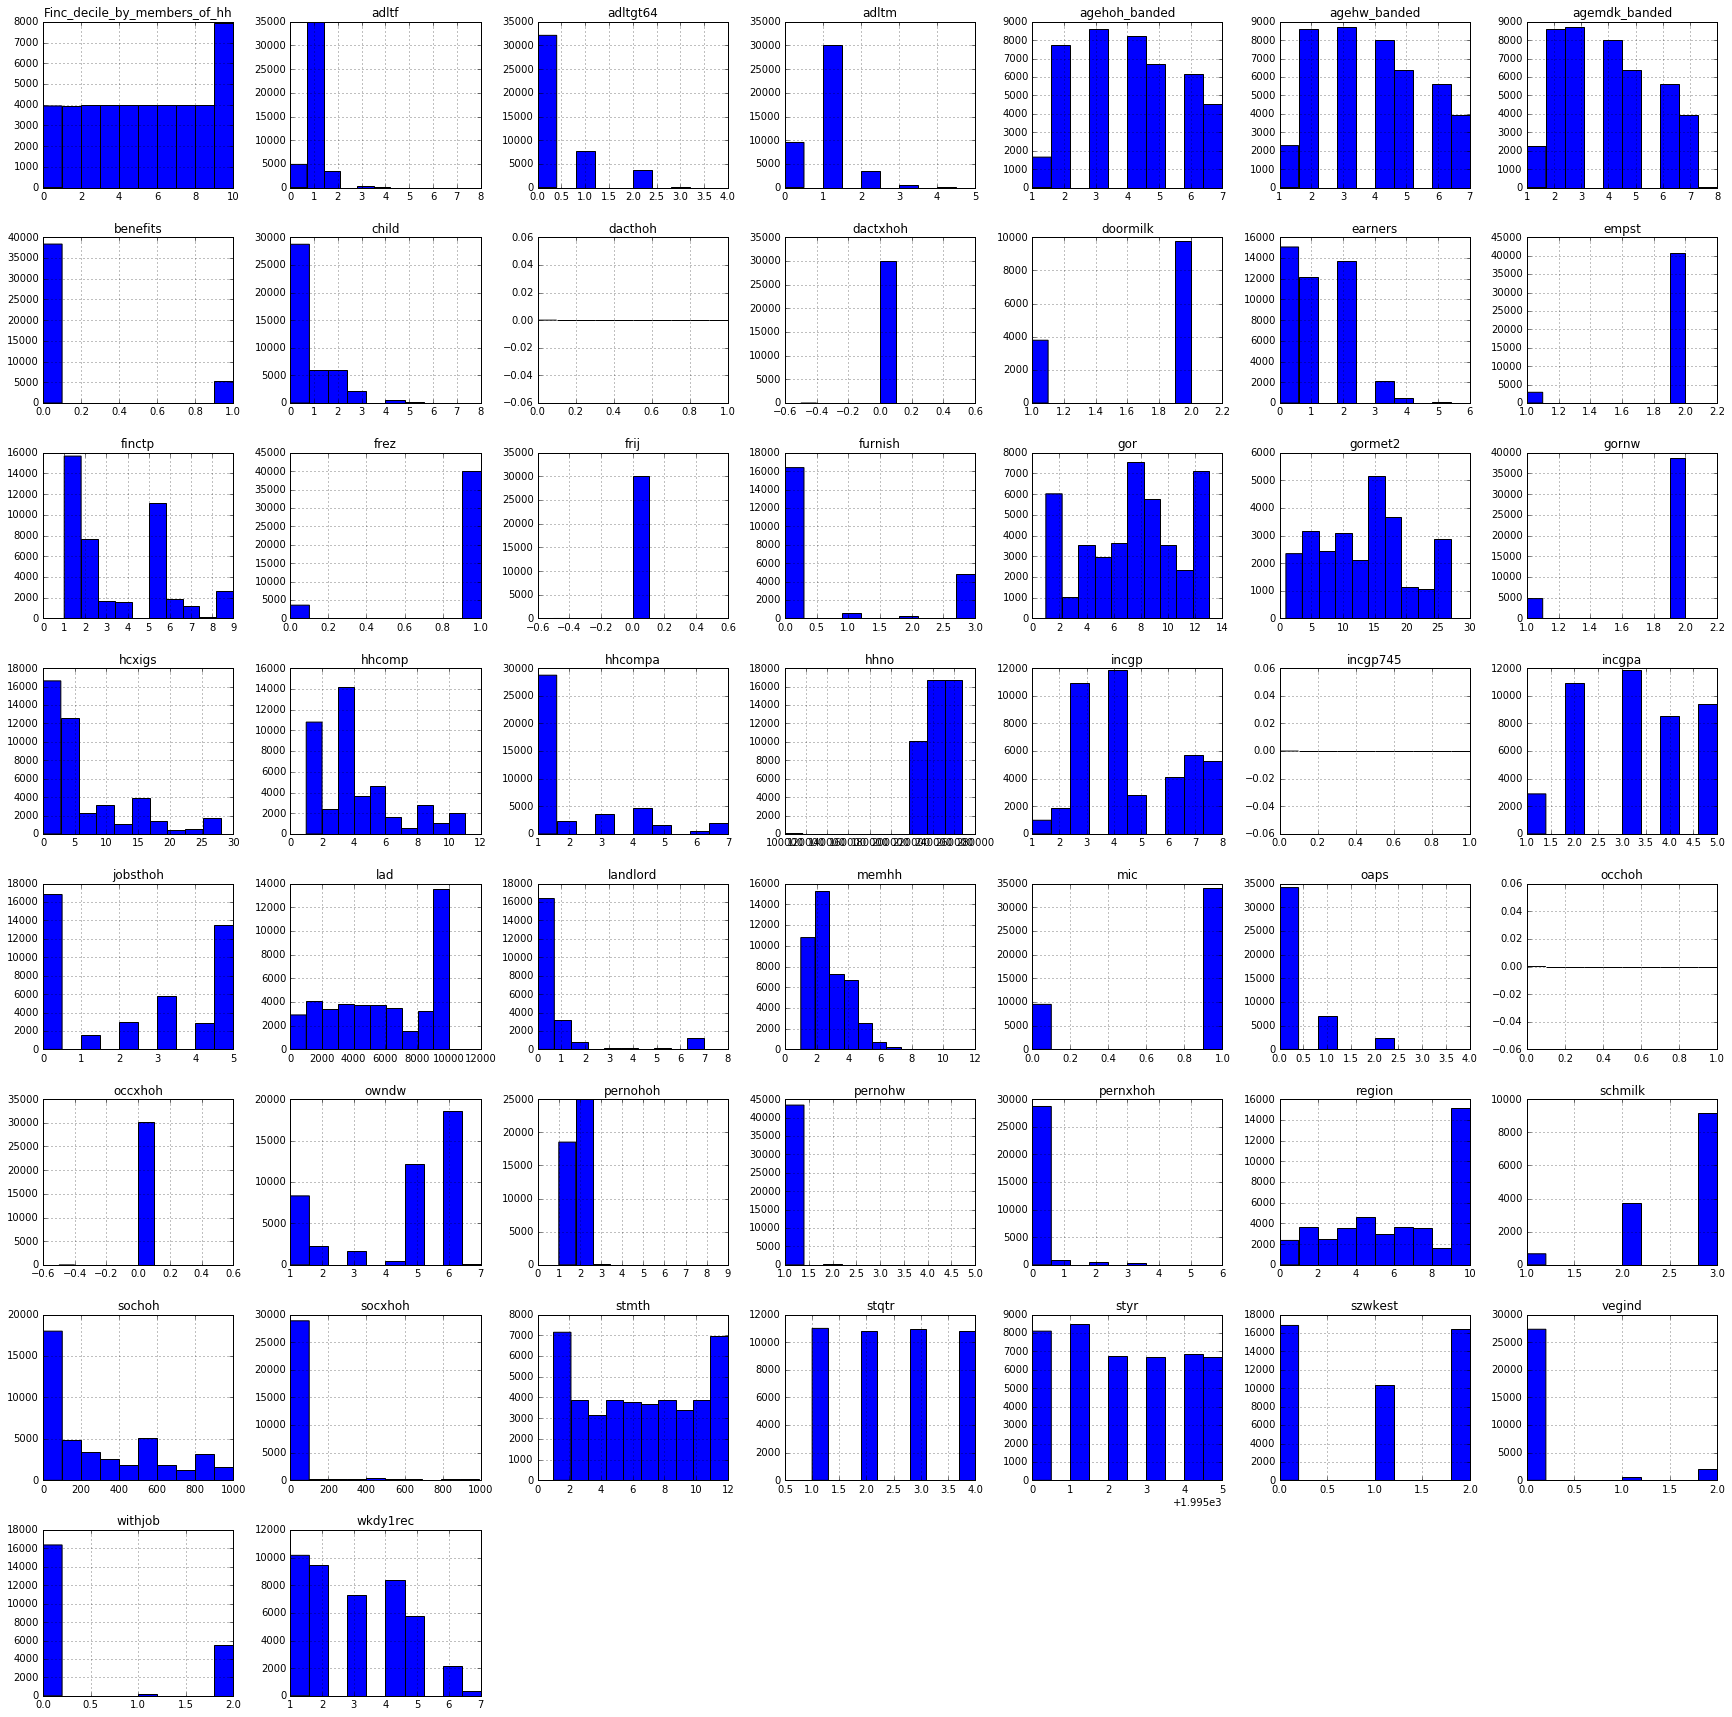

In [8]:
df.hist(figsize = (30,30))

In [9]:
print "Regions:"
df.region_text.value_counts().sort_index()

Regions:


EAST ANGLIA            1664
EAST MIDLANDS          2984
NORTH WEST             4602
NORTHERN               2453
NORTHERN IRELAND       3459
SCOTLAND               3682
SOUTH EAST            11670
SOUTH WEST             3546
WALES                  2359
WEST MIDLANDS          3667
YORKS & HUMBERSIDE     3538
Name: region_text, dtype: int64

In [10]:
print "Benefits:"
df.benefits.value_counts().sort_index()

Benefits:


0    38359
1     5265
Name: benefits, dtype: int64

In [11]:
print "Job status of head of household (hoh):"
df.job_status_hoh.value_counts().sort_index()

Job status of head of household (hoh):


APPRENTICES/EMPLOYEES NEC                13518
FOREMEN/SUPERVISORS                       2903
MANAGERS                                  5796
NOT APPLICABLE HOH UNEMPLOYED/RETIRED    16820
SELF EMPLOYED WITH EMPLOYEES              1606
SELF EMPLOYED WITHOUT EMPLOYEES           2981
Name: job_status_hoh, dtype: int64

In [12]:
print "Size of workplace of hoh:"
df.workplace.value_counts().sort_index()

Size of workplace of hoh:


NOT APPLICABLE HOH UNEMPLOYED/RETIRED      16820
WORKS FOR ESTABLISHMENT OF 25 OR MORE      16445
WORKS FOR ESTABLISHMENT OF LESS THAN 25    10359
Name: workplace, dtype: int64

In [13]:
print "Ownership of dwelling:"
df.ownhome.value_counts().sort_index()

Ownership of dwelling:


FURNISHED, RENTED            1672
OWNS OUTRIGHT               12149
OWNS WITH MORTGAGE          18617
RENT FREE                     461
SHARED OWNERSHIP               93
UNFURNISHED COUNCIL          8325
UNFURNISHED,OTHER,RENTED     2307
Name: ownhome, dtype: int64

In [14]:
print "Number of family members:"
df.memhh.value_counts().sort_index()

Number of family members:


1     10797
2     15250
3      7295
4      6706
5      2508
6       743
7       230
8        58
9        27
10       10
Name: memhh, dtype: int64

In [15]:
print "Income:"
print df.Finc_decile_by_members_of_hh.value_counts().sort_index()

Income:
0     3939
1     3948
2     3982
3     3961
4     3967
5     3971
6     3967
7     3978
8     3973
9     3969
10    3969
Name: Finc_decile_by_members_of_hh, dtype: int64


## 3.3. Food

### 3.3.a. Food items, groups and units

There are several files describing the food codes, groups, and units.

Essentially, there are **315 food items** (each in specific units like pints or grams), grouped into **24 food groups**. Each group has between 1 and 50 different foods.

In [16]:
# ===== FOOD ITEMS

df_min_maj = pd.DataFrame.from_csv(dataRefe+'Ref_ Minor and major foods.txt', sep='\t', index_col=None)
df_min_maj.columns=['minor', 'minor_text', 'major']

In [17]:
# ===== FOOD GROUPS

#184 "major" groups
df_maj_text = pd.DataFrame.from_csv(dataRefe+'Ref_ Major food codes.txt', sep='\t', index_col=None)
df_maj_text.columns=['major', 'major_text']

#24 more aggregated "groups"
df_grp_text = pd.DataFrame.from_csv(dataRefe+'Ref_ food groups (standard).txt', sep='\t', index_col=None)
df_grp_text.columns=['group','group_text']

#Intermediate mapping
df_mapping = pd.DataFrame.from_csv(dataRefe+'Ref_ Major-food group mapping.txt', sep='\t', index_col=None)
df_mapping.columns=['major','group']

#Selection of 24 groups from mapping
group24 = [4006, 9017, 22023, 31041, 46094, 100127, 129129, 135148, 150154, 155161, 162171, 172183, \
           184208, 210231, 233248, 251263, 264264, 267277, 281301, 304313, 314339, 340344, 350354, 380389]
df_maj_group = df_mapping[df_mapping['group'].isin(group24) == True]

In [18]:
# ===== UNITS

df_min_units = pd.DataFrame.from_csv(dataRefe+'Ref_MINFD_Minor_food_codes.txt', sep='\t', index_col=None)
df_min_units.columns=['minor','minor_text','units']
df_min_units.drop(['minor_text'], inplace=True, axis=1) #to avoid duplicate later

In [19]:
# ===== PUTTING IT ALL TOGETHER

df = pd.merge(df_min_maj, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')
df_groups = df

print len(df), "food items, each with", len(df.columns)," variables:", list(df.columns.values)

315 food items, each with 6  variables: ['minor', 'minor_text', 'major', 'major_text', 'group', 'group_text']


The 24 **food-groups**:
- have different numbers of food-items (from 1 to 50)
- may have a **mix of very different nutritional quality**
- are measured in different units (this is not shown here)

Here they are, in detail:

In [20]:
df = df_groups
list_of_groups = df.group_text.unique()
for g in list_of_groups:
    list_of_foods = df[df.group_text == g].minor_text
    print
    print "Group", g, "has", len(list_of_foods), "different foods:"
    print list_of_foods.as_matrix()


Group LIQUID WHOLEMILK, INC SCHOOL & WELFARE has 6 different foods:
['MILK  LIQUID  FULL PRICE' 'UHT LIQUID MILK, FULL PRICE'
 'STERILISED MILK, FULL PRICE' 'OTHER LIQUID MILK, FULL PRICE'
 'MILK  LIQUID  WELFARE' 'MILK  LIQUID  SCHOOL']

Group OTHER MILK & CREAM has 14 different foods:
['MILK  CONDENSED' 'MILK  DRIED  NATIONAL' 'INFANT MILKS' 'MILK  INSTANT'
 'YOGHURT' 'FROMAGE FRAIS' 'SKIMMED MILK' 'FULLY SKIMMED MILK'
 'SEMI AND OTHER SKIMMED MILKS' 'OTHER MILK, INC SKIMMED'
 'OTHER MILK, NOT SKIMMED' 'DAIRY DESSERTS' 'OTHER MILKS' 'CREAM']

Group TOTAL CHEESE has 7 different foods:
['CHEESE NAT HARD CHEDDAR AND CHEDDAR TYPE'
 'CHEESE NAT HARD OTHER UK VAR & FOR EQUIV'
 'CHEESE NAT HARD EDAM & OTHER CONTINENTAL' 'CHEESE NATURAL SOFT'
 'COTTAGE CHEESE' 'OTHER CHEESE NATURAL SOFT' 'CHEESE PROCESSED']

Group ALL CARCASE MEAT has 17 different foods:
['BEEF STEAK INCL STEWING AND STK & KIDNEY'
 'BEEF JOINTS ON THE BONE INCL SIDES' 'BEEF JOINTS BONED'
 'BEEF STEAK (LESS EXPENSIVE)' 'BEEF

### 3.3.b. Weekly purchases

For the families described above, we have their "diary" information: what quantities they bought of 300+ food items during one week.

In [21]:
df_purc1995 = pd.DataFrame.from_csv(data+'1995 diary data.txt', sep='\t', index_col=None)
df_purc1996 = pd.DataFrame.from_csv(data+'1996 diary data.txt', sep='\t', index_col=None)
df_purc1997 = pd.DataFrame.from_csv(data+'1997 diary data.txt', sep='\t', index_col=None)
df_purc1998 = pd.DataFrame.from_csv(data+'1998 diary data.txt', sep='\t', index_col=None)
df_purc1999 = pd.DataFrame.from_csv(data+'1999 diary data.txt', sep='\t', index_col=None)
df_purc2000 = pd.DataFrame.from_csv(data+'2000 diary data.txt', sep='\t', index_col=None)

df_purc1995['survyear'] = '1995'
df_purc1996['survyear'] = '1996'
df_purc1997['survyear'] = '1997'
df_purc1998['survyear'] = '1998'
df_purc1999['survyear'] = '1999'
df_purc2000['survyear'] = '2000'

list_of_years = [df_purc1995, df_purc1996, df_purc1997, df_purc1998, df_purc1999, df_purc2000]

df = pd.concat(list_of_years)
df.columns=['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear']
df_diary8 = df

In [22]:
# ===== idem + adding "_text", "group" and "unit" variables
df = pd.merge(df_diary8, df_min_maj, how='left', on='minor')
df = pd.merge(df, df_min_units, how='left', on='minor')
df = pd.merge(df, df_maj_text, how='left', on='major')
df = pd.merge(df, df_maj_group, how='left', on='major')
df = pd.merge(df, df_grp_text, how='left', on='group')

In [23]:
# ===== DIARY WITH 14, 10 or 6 VARIABLES
df_diary14 = df
df_diary10 = df[['survyear', 'hhno', 'quantity', 'units', 'minor_text', \
                 'group_text', 'minor', 'major', 'major_text', 'group']]
df_diary6  = df[['survyear', 'hhno', 'minor_text', 'quantity', 'units', 'group_text']]

In [24]:
df = df_diary14
print "DIARY ENTRIES: in 1995-2000, {0:4} families bought {1:6} items, {2:3} foods in {3:2} groups.".\
    format(len(df.hhno.unique()), len(df), len(df.minor_text.unique()), len(df.group_text.unique()))
print len(df.columns), "variables:", list(df.columns.values)

DIARY ENTRIES: in 1995-2000, 42960 families bought 1581381 items, 243 foods in 24 groups.
14 variables: ['hhno', 'fooditem', 'logday', 'purchasevalue', 'minor', 'quantity', 'purchasefree', 'survyear', 'minor_text', 'major', 'units', 'major_text', 'group', 'group_text']


### 3.3.c. Weekly purchases per family

The above information is summarized below, giving us food items and food groups per family. For brevity, only the summary of the groups is shown.

In [25]:
# ===== FOODS PER HOUSEHOLD =====
df = df_diary14
df_household_foods = pd.crosstab(df.hhno, df.minor_text, values = df.quantity, aggfunc=np.sum)
df_household_foods = df_household_foods.fillna(0)
df_household_foods.reset_index(level=0, inplace=True)
df = df_household_foods

In [26]:
# ===== FOOD-GROUPS PER HOUSEHOLD =====
df = df_diary14[['hhno', 'quantity', 'group_text']]
df_household_groups = pd.crosstab(df.hhno, df.group_text, values = df.quantity, aggfunc=np.sum)
df_household_groups = df_household_groups.fillna(0)
df_household_groups.reset_index(level=0, inplace=True)
df = df_household_groups

In [27]:
# ===== HOUSEHOLDS WITH THEIR FOOD-GROUPS =====
df = pd.merge(df_households, df_household_groups, how='left', on='hhno')
df_hh_with_food_groups = df
print "So we have {0:5} diary entries from {1:4} families".format(len(df_diary14), len(df_households))
print "and for each family we now have: survyear + 50 demographic variables + 24 food-group variables."
df.head()

So we have 1581381 diary entries from 43624 families
and for each family we now have: survyear + 50 demographic variables + 24 food-group variables.


,hhno,gormet2,region,lad,styr,stmth,mic,frez,owndw,memhh,schmilk,incgp,occhoh,sochoh,dacthoh,Finc_decile_by_members_of_hh,finctp,pernohoh,pernohw,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,stqtr,country,gor,agemdk_banded,incgpa,hhcomp,hhcompa,hcxigs,dat1rec,doormilk,frij,earners,occxhoh,socxhoh,dactxhoh,szwkest,empst,wkdy1rec,vegind,gornw,pernxhoh,jobsthoh,incgp745,withjob,landlord,furnish,benefits,survyear,region_text,income_group,job_status_hoh,workplace,ownhome,ALCOHOLIC DRINKS,ALL BREAD,ALL CARCASE MEAT,ALL FATS,ALL FISH,ALL NON-CARCASE MEAT AND MEAT PRODUCTS,ALL OTHER FOODS,ALL PROCESSED VEGETABLES,BEVERAGES,"BISCUITS, CAKES, BUNS, CRISPBREADS","CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS",CONFECTIONERY,EGGS,FLOUR,FRESH FRUIT,FRESH GREEN VEGETABLES,FRUIT & FRUIT PRODS. NOT FRESH,"LIQUID WHOLEMILK, INC SCHOOL & WELFARE",OTHER FRESH VEGETABLES,OTHER MILK & CREAM,POTATOES,SOFT DRINKS,SUGAR AND PRESERVES,TOTAL CHEESE
0,224203,NaN,0,14,1995,1,1,1,6,3,NaN,1,NaN,220,NaN,10,7,2,1,4.0,4.0,1,1,1,0,0,1,Wales,11,4.0,1,4,3,9,3/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,3,0.0,2,0.0,1,NaN,NaN,NaN,NaN,0,1995,WALES,A1,SELF EMPLOYED WITH EMPLOYEES,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS WITH MORTGAGE,600.0,34.38,15.52,17.63,8.00,49.08,12.34,114.97,15.86,39.98,61.70,0.0,0.0,0.0,17.12,0.00,0.00,7.0,33.50,7.00,33.6,0.00,0.00,0.00
1,224204,NaN,0,14,1995,1,1,1,5,1,NaN,3,NaN,611,NaN,0,7,1,1,3.0,3.0,1,0,0,0,0,1,Wales,11,3.0,2,1,1,2,4/1/1935 00:00:00,NaN,0.0,1,0.0,0.0,0.0,1,2,4,2.0,2,0.0,4,NaN,NaN,NaN,NaN,0,1995,WALES,B,FOREMEN/SUPERVISORS,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT,200.0,84.63,0.00,0.00,0.00,0.00,27.51,28.21,1.76,0.00,3.52,0.0,0.0,0.0,0.00,14.00,3.52,0.0,32.00,7.37,80.0,70.38,35.27,0.00
2,224205,NaN,0,14,1995,1,0,0,5,2,NaN,4,NaN,221,NaN,0,7,1,1,4.0,4.0,1,1,0,0,0,1,Wales,11,4.0,3,3,1,3,5/1/1935 00:00:00,NaN,0.0,2,0.0,0.0,0.0,1,2,5,0.0,2,0.0,5,NaN,NaN,NaN,NaN,0,1995,WALES,C,APPRENTICES/EMPLOYEES NEC,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT,0.0,93.57,71.23,17.63,19.51,55.35,0.00,14.81,21.15,42.32,136.00,0.0,12.0,0.0,100.00,24.88,105.58,0.0,85.27,10.67,80.0,0.00,47.27,8.88
3,224206,NaN,0,14,1995,1,1,1,5,2,NaN,3,NaN,110,NaN,0,7,2,1,5.0,5.0,1,1,0,0,0,1,Wales,11,5.0,2,3,1,2,3/1/1935 00:00:00,NaN,0.0,2,0.0,0.0,0.0,2,2,3,0.0,2,0.0,3,NaN,NaN,NaN,NaN,0,1995,WALES,B,MANAGERS,WORKS FOR ESTABLISHMENT OF 25 OR MORE,OWNS OUTRIGHT,0.0,60.41,34.00,17.62,40.51,120.88,0.00,14.81,8.81,5.29,33.97,0.0,6.0,0.0,109.50,16.00,44.00,0.0,69.31,14.51,0.0,17.59,23.98,8.00
4,224207,NaN,0,14,1995,1,1,0,1,1,NaN,8,NaN,1,NaN,1,1,1,1,7.0,7.0,0,1,0,1,1,1,Wales,11,7.0,5,1,1,0,2/1/1935 00:00:00,NaN,0.0,0,0.0,0.0,0.0,0,2,2,0.0,2,0.0,0,NaN,NaN,NaN,NaN,0,1995,WALES,OAP,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,UNFURNISHED COUNCIL,70.0,14.10,16.00,8.81,10.58,29.09,0.00,0.00,8.81,12.81,17.63,0.0,6.0,0.0,0.00,0.00,0.00,2.0,16.00,0.00,0.0,0.00,0.00,0.00


In [28]:
df_hh_with_food_groups[['ALCOHOLIC DRINKS', 'ALL BREAD', 'ALL CARCASE MEAT', 'ALL FATS', 'ALL FISH', \
                       'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL OTHER FOODS', \
                       'ALL PROCESSED VEGETABLES', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', \
                       'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS', 'CONFECTIONERY', 'EGGS', 'FLOUR', \
                       'FRESH FRUIT', 'FRESH GREEN VEGETABLES', 'FRUIT & FRUIT PRODS. NOT FRESH', \
                       'LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER FRESH VEGETABLES', \
                       'OTHER MILK & CREAM', 'POTATOES', 'SOFT DRINKS', 'SUGAR AND PRESERVES', \
                       'TOTAL CHEESE']].describe().transpose()

/home/lucas/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,count,mean,std,min,25%,50%,75%,max
ALCOHOLIC DRINKS,42960.0,97.697272,290.274641,0.0,NaN,NaN,NaN,12410.00
ALL BREAD,42960.0,67.449993,55.608598,0.0,NaN,NaN,NaN,1039.85
ALL CARCASE MEAT,42960.0,22.072882,40.630323,0.0,NaN,NaN,NaN,2608.00
ALL FATS,42960.0,18.516434,29.822182,0.0,NaN,NaN,NaN,1416.61
ALL FISH,42960.0,12.818207,20.488979,0.0,NaN,NaN,NaN,705.46
ALL NON-CARCASE MEAT AND MEAT PRODUCTS,42960.0,62.479956,65.638274,0.0,NaN,NaN,NaN,1380.12
ALL OTHER FOODS,42960.0,38.478998,65.816833,0.0,NaN,NaN,NaN,1662.60
ALL PROCESSED VEGETABLES,42960.0,50.390271,61.583813,0.0,NaN,NaN,NaN,934.05
BEVERAGES,42960.0,5.283805,9.312322,0.0,NaN,NaN,NaN,352.72
"BISCUITS, CAKES, BUNS, CRISPBREADS",42960.0,24.626750,29.126970,0.0,NaN,NaN,NaN,340.89


# 4. Data preparation for modeling

For each household, we want:
- first, a score of "good food": a number that summarises the food each family buys.
- and then a categorisation of that score.

## 4.1. Food-groups: good and bad

I'm not a nutrition expert, but here's a rough idea of how I'd approach this:

- Low nutritional value: 'ALCOHOLIC DRINKS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', 'SUGAR AND PRESERVES'
- Some food-groups have mixed nutritional value ('ALL BREAD', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS', 'ALL OTHER FOODS', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS'), and they are included as "good food".
- Generally good food: the remaining food groups.

In [29]:
all_groups = df_grp_text.group_text.tolist()
#all_groups = df_groups.group_text.unique()

bad_groups = ['ALCOHOLIC DRINKS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY',\
              'SOFT DRINKS', 'SUGAR AND PRESERVES']

good_groups = [x for x in all_groups if x not in bad_groups and x is not np.nan]
print "bad groups:", bad_groups
print "\ngood (or mixed) groups:", good_groups

df = df_diary14[['hhno', 'quantity', 'group_text']]
df_good = df[df.group_text.isin(good_groups)]
df_bad = df[df.group_text.isin(bad_groups)]
#print "All food purchases split in good and bad:", len(df), len(df_good), len(df_bad)

bad groups: ['ALCOHOLIC DRINKS', 'BEVERAGES', 'BISCUITS, CAKES, BUNS, CRISPBREADS', 'CONFECTIONERY', 'SOFT DRINKS', 'SUGAR AND PRESERVES']

good (or mixed) groups: ['LIQUID WHOLEMILK, INC SCHOOL & WELFARE', 'OTHER MILK & CREAM', 'TOTAL CHEESE', 'ALL CARCASE MEAT', 'ALL NON-CARCASE MEAT AND MEAT PRODUCTS', 'ALL FISH', 'EGGS', 'ALL FATS', 'POTATOES', 'FRESH GREEN VEGETABLES', 'OTHER FRESH VEGETABLES', 'ALL PROCESSED VEGETABLES', 'FRESH FRUIT', 'FRUIT & FRUIT PRODS. NOT FRESH', 'ALL BREAD', 'FLOUR', 'CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS', 'ALL OTHER FOODS']


## 4.2. Score: number of times each kind of food was bought

Note: I also tried adding up "quantities" (as commented-out in the cell below), but the frequency distribution came out too skewed, so I discarded it.

In [30]:
# ===== SUM_GOOD = ALL TIMES GOOD FOODs ARE BOUGHT

df = df_good
print df.shape
df_household_good_groups = pd.crosstab(df.hhno, df.group_text) #, values = df.quantity, aggfunc=np.sum
df_household_good_groups = df_household_good_groups.fillna(0)
df_household_good_groups.reset_index(level=0, inplace=True)

df = df_household_good_groups
col_list= list(df)
col_list.remove('hhno')
df['sum_good'] = df[col_list].sum(axis=1)
df_household_good_groups = df

df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df_hh_with_good_food_groups = df

(1319495, 3)


In [31]:
# ===== SUM_BAD = ALL TIMES BAD FOODs ARE BOUGHT

df = df_bad
print df.shape
df_household_bad_groups = pd.crosstab(df.hhno, df.group_text) #, values = df.quantity, aggfunc=np.sum
df_household_bad_groups = df_household_bad_groups.fillna(0)
df_household_bad_groups.reset_index(level=0, inplace=True)
df = df_household_bad_groups

col_list= list(df)
col_list.remove('hhno')
df['sum_bad'] = df[col_list].sum(axis=1)
df_household_bad_groups = df

df = pd.merge(df_households, df_household_bad_groups, how='left', on='hhno')
df_hh_with_bad_food_groups = df

(261886, 3)


In [32]:
df = pd.merge(df_households, df_household_good_groups, how='left', on='hhno')
df = pd.merge(df, df_household_bad_groups, how='left', on='hhno')
df = df.fillna(0.1)
df['how_good'] = df['sum_good'] / (df['sum_good'] + df['sum_bad'])
df['how_bad'] = df['sum_bad'] / (df['sum_good'] +  df['sum_bad'])
df_hh_with_all_food_groups = df

The result of the created variables is shown below, both numerically and graphically.

In [33]:
# Numerical comparison of the created variables

print df[['sum_good', 'sum_bad', 'how_good', 'how_bad']].describe()
print "SUM GOOD:",  len(df[df.sum_good == 0]), "are zero. ", len(df[df.sum_good == np.nan]), "are NaN."
print "SUM BAD:",   len(df[df.sum_bad == 0]),  "are zero. ", len(df[df.sum_bad == np.nan]),  "are NaN."
print "HOW GOOD: ", len(df[df.how_good == 0]), "are zero. ", len(df[df.how_good == np.nan]), "are NaN."
print "HOW BAD",    len(df[df.how_bad == 0]), " are zero. ", len(df[df.how_bad == np.nan]),  "are NaN."

           sum_good       sum_bad      how_good       how_bad
count  43624.000000  43624.000000  43624.000000  43624.000000
mean      30.248629      6.014047      0.836674      0.163326
std       17.464982      5.154138      0.108092      0.108092
min        0.100000      0.100000      0.014085      0.001783
25%       17.000000      2.000000      0.782609      0.090909
50%       28.000000      5.000000      0.848485      0.151515
75%       41.000000      9.000000      0.909091      0.217391
max      142.000000     57.000000      0.998217      0.985915
SUM GOOD: 0 are zero.  0 are NaN.
SUM BAD: 0 are zero.  0 are NaN.
HOW GOOD:  0 are zero.  0 are NaN.
HOW BAD 0  are zero.  0 are NaN.


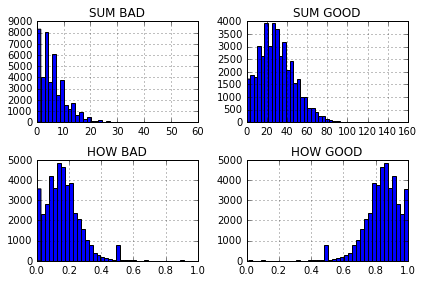

In [34]:
# Graphical comparison of the created variables

fig, axes = plt.subplots(nrows=2, ncols=2)
df.sum_bad.hist(ax=axes[0,0], bins = 40).set_title('SUM BAD')
df.sum_good.hist(ax=axes[0,1], bins = 40).set_title('SUM GOOD')
df.how_bad.hist(ax=axes[1,0], bins = 40).set_title('HOW BAD')
df.how_good.hist(ax=axes[1,1], bins = 40).set_title('HOW GOOD')
plt.tight_layout()

## 4.3. Categories: "good cart" vs "bad cart"

The way they have been defined, half of the families have "good carts", and the other half have "bad carts".

In [35]:
df = df_hh_with_all_food_groups
df['good_cart'] = df.how_good > 0.848485  # median
df.good_cart = df.good_cart.astype(int)
df_cat = df
print df_cat.good_cart.value_counts()

0    21862
1    21762
Name: good_cart, dtype: int64


In [36]:
df_cat.head()

,hhno,gormet2,region,lad,styr,stmth,mic,frez,owndw,memhh,schmilk,incgp,occhoh,sochoh,dacthoh,Finc_decile_by_members_of_hh,finctp,pernohoh,pernohw,agehoh_banded,agehw_banded,adltm,adltf,child,oaps,adltgt64,stqtr,country,gor,agemdk_banded,incgpa,hhcomp,hhcompa,hcxigs,dat1rec,doormilk,frij,earners,occxhoh,socxhoh,dactxhoh,szwkest,empst,wkdy1rec,vegind,gornw,pernxhoh,jobsthoh,incgp745,withjob,landlord,furnish,benefits,survyear,region_text,income_group,job_status_hoh,workplace,ownhome,ALL BREAD,ALL CARCASE MEAT,ALL FATS,ALL FISH,ALL NON-CARCASE MEAT AND MEAT PRODUCTS,ALL OTHER FOODS,ALL PROCESSED VEGETABLES,"CEREALS, EXCL. BREAD,BUNS,CAKES,BISCUITS",EGGS,FLOUR,FRESH FRUIT,FRESH GREEN VEGETABLES,FRUIT & FRUIT PRODS. NOT FRESH,"LIQUID WHOLEMILK, INC SCHOOL & WELFARE",OTHER FRESH VEGETABLES,OTHER MILK & CREAM,POTATOES,TOTAL CHEESE,sum_good,ALCOHOLIC DRINKS,BEVERAGES,"BISCUITS, CAKES, BUNS, CRISPBREADS",CONFECTIONERY,SOFT DRINKS,SUGAR AND PRESERVES,sum_bad,how_good,how_bad,good_cart
0,224203,0.1,0,14,1995,1,1,1,6,3,0.1,1,0.1,220,0.1,10,7,2,1,4.0,4.0,1,1,1,0,0,1,Wales,11,4.0,1,4,3,9,3/1/1935 00:00:00,0.1,0.0,1,0.0,0.0,0.0,1,2,3,0.0,2,0.0,1,0.1,0.1,0.1,0.1,0,1995,WALES,A1,SELF EMPLOYED WITH EMPLOYEES,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS WITH MORTGAGE,2.0,1.0,1.0,1.0,5.0,1.0,9.0,4.0,0.0,0.0,1.0,0.0,0.0,6.0,2.0,6.0,1.0,0.0,40.0,1.0,2.0,4.0,0.0,0.0,0.0,7.0,0.851064,0.148936,1
1,224204,0.1,0,14,1995,1,1,1,5,1,0.1,3,0.1,611,0.1,0,7,1,1,3.0,3.0,1,0,0,0,0,1,Wales,11,3.0,2,1,1,2,4/1/1935 00:00:00,0.1,0.0,1,0.0,0.0,0.0,1,2,4,2.0,2,0.0,4,0.1,0.1,0.1,0.1,0,1995,WALES,B,FOREMEN/SUPERVISORS,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT,3.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,0.0,17.0,1.0,1.0,0.0,0.0,2.0,1.0,5.0,0.772727,0.227273,0
2,224205,0.1,0,14,1995,1,0,0,5,2,0.1,4,0.1,221,0.1,0,7,1,1,4.0,4.0,1,1,0,0,0,1,Wales,11,4.0,3,3,1,3,5/1/1935 00:00:00,0.1,0.0,2,0.0,0.0,0.0,1,2,5,0.0,2,0.0,5,0.1,0.1,0.1,0.1,0,1995,WALES,C,APPRENTICES/EMPLOYEES NEC,WORKS FOR ESTABLISHMENT OF LESS THAN 25,OWNS OUTRIGHT,7.0,3.0,1.0,2.0,6.0,0.0,1.0,8.0,2.0,0.0,3.0,2.0,1.0,0.0,5.0,8.0,1.0,1.0,51.0,0.0,2.0,5.0,0.0,0.0,2.0,9.0,0.850000,0.150000,1
3,224206,0.1,0,14,1995,1,1,1,5,2,0.1,3,0.1,110,0.1,0,7,2,1,5.0,5.0,1,1,0,0,0,1,Wales,11,5.0,2,3,1,2,3/1/1935 00:00:00,0.1,0.0,2,0.0,0.0,0.0,2,2,3,0.0,2,0.0,3,0.1,0.1,0.1,0.1,0,1995,WALES,B,MANAGERS,WORKS FOR ESTABLISHMENT OF 25 OR MORE,OWNS OUTRIGHT,4.0,2.0,2.0,4.0,5.0,0.0,1.0,3.0,1.0,0.0,9.0,1.0,2.0,0.0,6.0,9.0,0.0,1.0,50.0,0.0,1.0,1.0,0.0,1.0,1.0,4.0,0.925926,0.074074,1
4,224207,0.1,0,14,1995,1,1,0,1,1,0.1,8,0.1,1,0.1,1,1,1,1,7.0,7.0,0,1,0,1,1,1,Wales,11,7.0,5,1,1,0,2/1/1935 00:00:00,0.1,0.0,0,0.0,0.0,0.0,0,2,2,0.0,2,0.0,0,0.1,0.1,0.1,0.1,0,1995,WALES,OAP,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,UNFURNISHED COUNCIL,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,12.0,1.0,1.0,2.0,0.0,0.0,0.0,4.0,0.750000,0.250000,0


So now we have df_cat with one record per family, and for each family we have all the descriptive variables for the family, the number of times they bought food items for each of the food groups, the proportion of good and bad foods within the total purchases, and a variable that tell us if a specific family buys many bad foods.

# 5. Modeling

## 5.1. Preliminary exploration

Now, we need to look at which variables are good candidates for the model.

### 5.1.a. Numerical

First, let us look at all the variables in the "families" file, looking at the mean for each variable when we split the families into those with a "bad shopping-cart" (0) and those with a "good shopping-cart" (1).

In [37]:
df_cat.groupby('good_cart').mean().transpose()

good_cart,0,1
hhno,245853.379334,246058.053993
gormet2,8.325455,8.302431
region,5.721251,5.845419
lad,5784.744397,5921.327681
styr,1997.342009,1997.382823
stmth,6.561202,6.398217
mic,0.789635,0.774423
frez,0.916568,0.917701
owndw,4.422971,4.420641
memhh,2.649117,2.366786


### 5.1.b. Graphical

Now let's look at the same differences graphically, which will give us a sense of what categories of each variable have higher or smaller values of the "good cart" category.

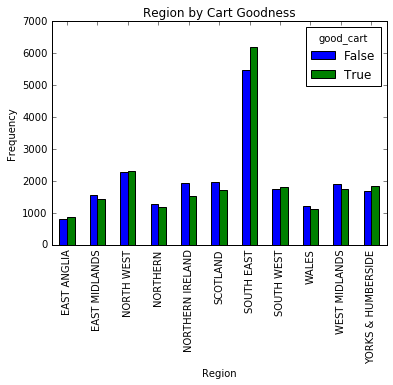

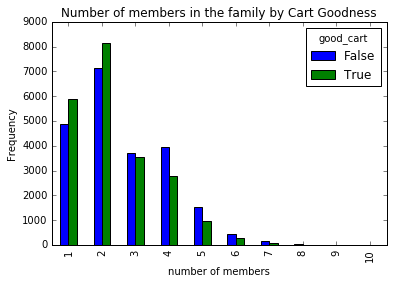

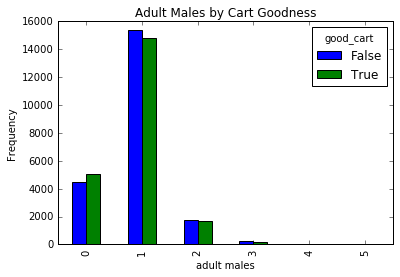

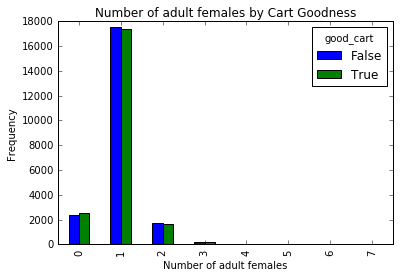

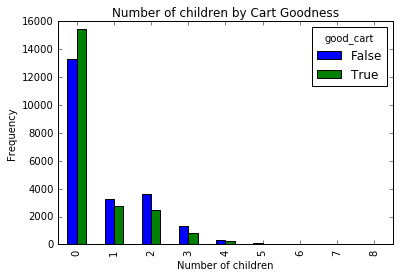

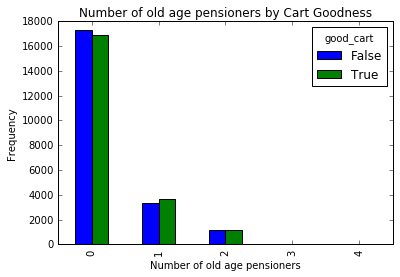

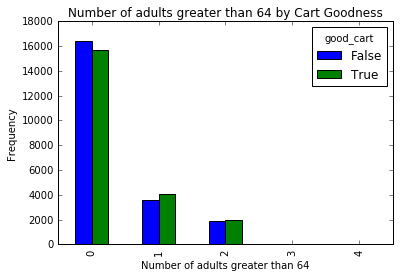

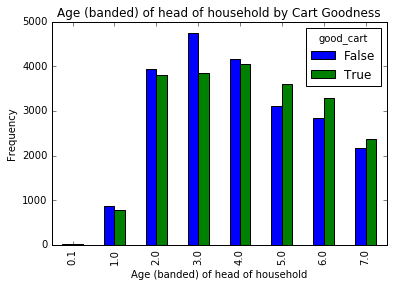

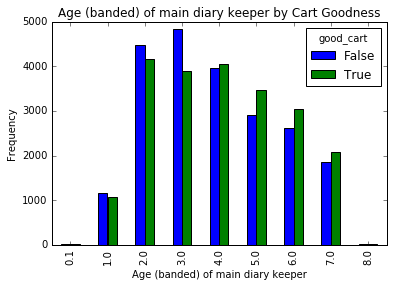

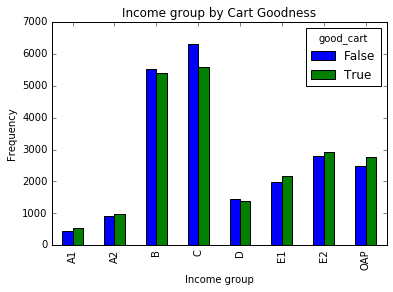

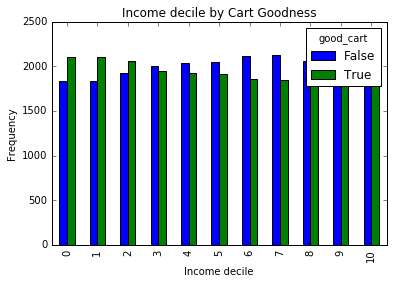

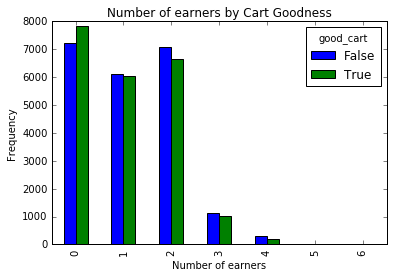

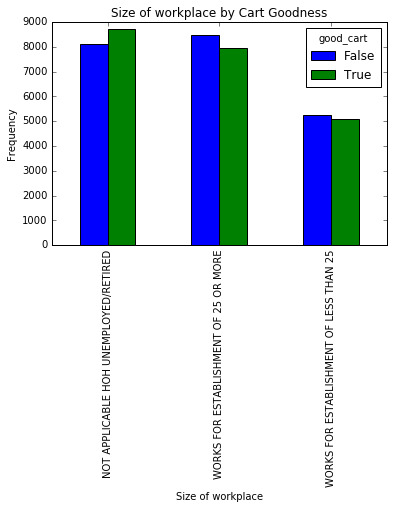

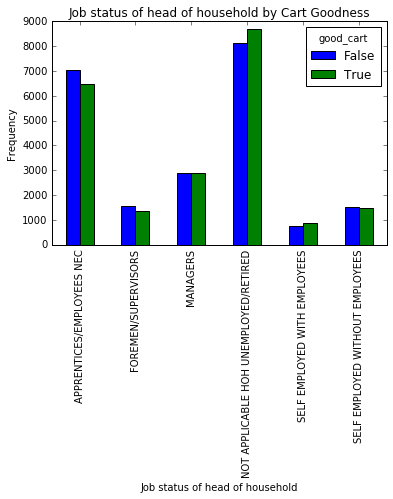

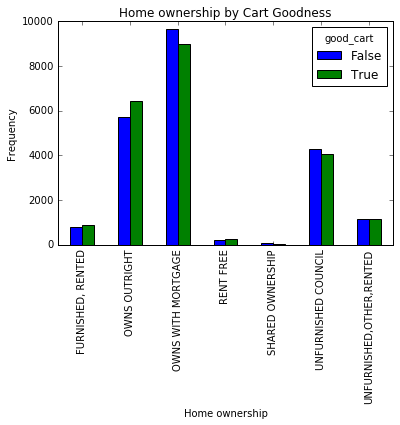

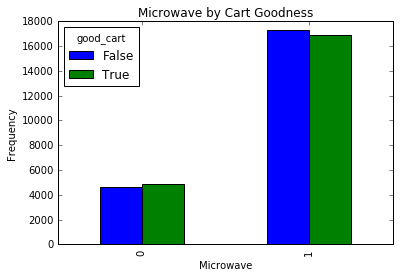

In [38]:
###### REGION

pd.crosstab(df_cat.region_text, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Region by Cart Goodness')
plt.xlabel('Region')
plt.ylabel('Frequency')

###### PEOPLE

#Number of members in the family
pd.crosstab(df_cat.memhh, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Number of members in the family by Cart Goodness')
plt.xlabel('number of members')
plt.ylabel('Frequency')

#Number of adult males
pd.crosstab(df_cat.adltm, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Adult Males by Cart Goodness')
plt.xlabel('adult males')
plt.ylabel('Frequency')

#Number of adult females
pd.crosstab(df_cat.adltf, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Number of adult females by Cart Goodness')
plt.xlabel('Number of adult females')
plt.ylabel('Frequency')

#Number of children
pd.crosstab(df_cat.child, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Number of children by Cart Goodness')
plt.xlabel('Number of children')
plt.ylabel('Frequency')

#Number of old age pensioners
pd.crosstab(df_cat.oaps, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Number of old age pensioners by Cart Goodness')
plt.xlabel('Number of old age pensioners')
plt.ylabel('Frequency')

#Number of adults greater than 64
pd.crosstab(df_cat.adltgt64, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Number of adults greater than 64 by Cart Goodness')
plt.xlabel('Number of adults greater than 64')
plt.ylabel('Frequency')

###### AGES

#Age (banded) of head of household
pd.crosstab(df_cat.agehoh_banded, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Age (banded) of head of household by Cart Goodness')
plt.xlabel('Age (banded) of head of household')
plt.ylabel('Frequency')

#Age (banded) of main diary keeper
pd.crosstab(df_cat.agemdk_banded, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Age (banded) of main diary keeper by Cart Goodness')
plt.xlabel('Age (banded) of main diary keeper')
plt.ylabel('Frequency')

###### INCOME AND JOBS

#Income group
pd.crosstab(df_cat.income_group, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Income group by Cart Goodness')
plt.xlabel('Income group')
plt.ylabel('Frequency')

#Income decile
pd.crosstab(df_cat.Finc_decile_by_members_of_hh, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Income decile by Cart Goodness')
plt.xlabel('Income decile')
plt.ylabel('Frequency')

#Number of earners
pd.crosstab(df_cat.earners, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Number of earners by Cart Goodness')
plt.xlabel('Number of earners')
plt.ylabel('Frequency')

#Size of workplace
pd.crosstab(df_cat.workplace, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Size of workplace by Cart Goodness')
plt.xlabel('Size of workplace')
plt.ylabel('Frequency')

#Job status of head of household
pd.crosstab(df_cat.job_status_hoh, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Job status of head of household by Cart Goodness')
plt.xlabel('Job status of head of household')
plt.ylabel('Frequency')

###### HOME AND GADGETS

#Home ownership
pd.crosstab(df_cat.ownhome, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Home ownership by Cart Goodness')
plt.xlabel('Home ownership')
plt.ylabel('Frequency')

#Having a microwave
pd.crosstab(df_cat.mic, df_cat.good_cart.astype(bool)).plot(kind='bar')
plt.title('Microwave by Cart Goodness')
plt.xlabel('Microwave')
plt.ylabel('Frequency')

## 5.2. Model

### 5.2.a. Prepare matrices

Several steps need to be taken:

- Select variables: identifier for each family, pre-selected demographic variables, and outcome variable ("good_cart")
- Rename variables so that they are easier to understand when looking at the results
- Create the matrices (and renaming the ugly variables)
- Flatten the y matrix

In [39]:
df = df_cat
df = df[['hhno', 'mic', 'frez', 'memhh', 'Finc_decile_by_members_of_hh', 'agehoh_banded', \
                 'agehw_banded', 'adltm', 'adltf', 'child', 'oaps', 'adltgt64', 'country', 'agemdk_banded',\
                 'frij', 'earners', 'vegind', 'withjob', 'landlord', 'furnish', 'benefits', 'survyear',\
                 'region_text', 'income_group', 'job_status_hoh', 'workplace', 'ownhome', 'good_cart']]
df.columns = ['hhno', 'micro', 'freez', 'people', 'income', 'age_head', 'age_hwife', 'males', 'females',\
                  'children', 'oaps', 'seniors', 'country', 'age_reporter', 'fridge', 'earners', 'veget', \
                  'withjob', 'landlord', 'furnish', 'benefits', 'survyear', 'region', 'income_group', \
                  'job_status', 'workplace', 'own_home', 'good_cart']
df = df[['hhno', 'good_cart', \
                 'veget', \
                 'micro', 'freez', 'fridge', 'own_home', 'landlord', 'furnish', \
                 'people', 'males', 'females', 'children', 'oaps', 'seniors', 'earners', \
                 'age_head', 'age_hwife', 'age_reporter', \
                 'income', 'income_group', 'benefits', 'workplace', 'job_status', 'withjob', \
                 'country', 'region', 'survyear']]
df_clean = df
df.head()

,hhno,good_cart,veget,micro,freez,fridge,own_home,landlord,furnish,people,males,females,children,oaps,seniors,earners,age_head,age_hwife,age_reporter,income,income_group,benefits,workplace,job_status,withjob,country,region,survyear
0,224203,1,0.0,1,1,0.0,OWNS WITH MORTGAGE,0.1,0.1,3,1,1,1,0,0,1,4.0,4.0,4.0,10,A1,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,SELF EMPLOYED WITH EMPLOYEES,0.1,Wales,WALES,1995
1,224204,0,2.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,1,1,0,0,0,0,1,3.0,3.0,3.0,0,B,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,FOREMEN/SUPERVISORS,0.1,Wales,WALES,1995
2,224205,1,0.0,0,0,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,4.0,4.0,4.0,0,C,0,WORKS FOR ESTABLISHMENT OF LESS THAN 25,APPRENTICES/EMPLOYEES NEC,0.1,Wales,WALES,1995
3,224206,1,0.0,1,1,0.0,OWNS OUTRIGHT,0.1,0.1,2,1,1,0,0,0,2,5.0,5.0,5.0,0,B,0,WORKS FOR ESTABLISHMENT OF 25 OR MORE,MANAGERS,0.1,Wales,WALES,1995
4,224207,0,0.0,1,0,0.0,UNFURNISHED COUNCIL,0.1,0.1,1,0,1,0,1,1,0,7.0,7.0,7.0,1,OAP,0,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,NOT APPLICABLE HOH UNEMPLOYED/RETIRED,0.1,Wales,WALES,1995


In [40]:
yall, Xall = dmatrices('good_cart ~ veget + micro + freez + fridge + own_home + landlord + furnish + \
                  people + males + females + children + oaps + seniors + earners + \
                  age_head + age_hwife + age_reporter + \
                  income + income_group + benefits + workplace + job_status + withjob + \
                  country + region + survyear', df_clean, return_type="dataframe")

In [41]:
yall.head()

,good_cart
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0


In [42]:
# flatten y into a 1-D array
yall = np.ravel(yall)
print yall

[ 1.  0.  1. ...,  0.  1.  1.]


### 5.2.b. LR with whole dataset

In [43]:
# instanciate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(Xall, yall)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
# check the accuracy
model.score(Xall, yall)

0.55726205758298186

In [45]:
yall.mean()

0.49885384192187787

The model is only slightly better than predicting at random: if we predicted randomly, we'd get it right with 50% of the families (the a priori probability because both groups are of equal size), and with the model we have 55% accuracy.

### 5.2.c. Coefficients and Odds Ratios

The model we've just built gives us coefficients for each of the variables, but not all are equally predictive power. We're interested in the coefficient, and more importantly in the appropriate Odds Ratio, so that we'll know how to select which variables to keep and which we might drop.

In [46]:
# examine the coefficients and the ORs --- SORTED BY VARIABLE
pd.DataFrame(zip(Xall.columns, np.transpose(model.coef_), np.transpose(np.exp(model.coef_))))

,0,1,2
0,Intercept,[0.186851832761],[1.20544866382]
1,own_home[T.OWNS OUTRIGHT],[-0.00784560133794],[0.992185095063]
2,own_home[T.OWNS WITH MORTGAGE],[-0.0513656225411],[0.949931290739]
3,own_home[T.RENT FREE],[0.152341260134],[1.16455758571]
4,own_home[T.SHARED OWNERSHIP],[-0.354773230451],[0.701332466024]
5,own_home[T.UNFURNISHED COUNCIL],[-0.0259329858701],[0.974400386015]
6,"own_home[T.UNFURNISHED,OTHER,RENTED]",[0.0195802862997],[1.01977323739]
7,income_group[T.A2],[-0.121175380597],[0.885878580054]
8,income_group[T.B],[-0.205801613119],[0.813994546105]
9,income_group[T.C],[-0.314607185322],[0.730075602363]


In [47]:
# examine the coefficients and the ORs --- SORTED BY the OR
df_coef = pd.DataFrame(zip(Xall.columns, np.transpose(model.coef_), np.transpose(np.exp(model.coef_))))
df_coef.sort_values(2)

,0,1,2
11,income_group[T.E1],[-0.358377279455],[0.698809378845]
4,own_home[T.SHARED OWNERSHIP],[-0.354773230451],[0.701332466024]
9,income_group[T.C],[-0.314607185322],[0.730075602363]
12,income_group[T.E2],[-0.30057635848],[0.740391366841]
10,income_group[T.D],[-0.292750939455],[0.746207968518]
13,income_group[T.OAP],[-0.275669835203],[0.759063505442]
8,income_group[T.B],[-0.205801613119],[0.813994546105]
48,children,[-0.148178424937],[0.862277249452]
7,income_group[T.A2],[-0.121175380597],[0.885878580054]
49,oaps,[-0.114906482121],[0.891449506476]


Let's focus on the extremes: those values of OR which are further appart from 1 (OR= 0.91 or less, 1.10 or more):

In [48]:
print df_coef.sort_values(2).head(18)
print df_coef.sort_values(2).tail(7)

                               0                   1                 2
11            income_group[T.E1]   [-0.358377279455]  [0.698809378845]
4   own_home[T.SHARED OWNERSHIP]   [-0.354773230451]  [0.701332466024]
9              income_group[T.C]   [-0.314607185322]  [0.730075602363]
12            income_group[T.E2]    [-0.30057635848]  [0.740391366841]
10             income_group[T.D]   [-0.292750939455]  [0.746207968518]
13           income_group[T.OAP]   [-0.275669835203]  [0.759063505442]
8              income_group[T.B]   [-0.205801613119]  [0.813994546105]
48                      children   [-0.148178424937]  [0.862277249452]
7             income_group[T.A2]   [-0.121175380597]  [0.885878580054]
49                          oaps   [-0.114906482121]  [0.891449506476]
32       region[T.WEST MIDLANDS]   [-0.113015804528]  [0.893136544403]
26            region[T.NORTHERN]   [-0.109714448846]  [0.896089978294]
27    region[T.NORTHERN IRELAND]    [-0.10292736153]  [0.902192504984]
21    

It appears that having a lower value of the income_group variable reduces the probability of having a good shopping cart. ("The poor eat less well".) Other variables ('region', 'children') appear to have a similar effect.

On the other hand, having a job status of "self-employment with employees", having a "rent free" home, and being "withjob", seem to be associated with a higher probability of having a better shopping cart in terms of more healthy food items.

As a sidenote, and just to make sure we're reading the "income_group" appropriately, let's see its relationship with "income" (the "deciles" variable):

In [49]:
df_clean.groupby('income_group').income.mean().sort_values()

income_group
OAP    1.824952
E2     1.950237
D      2.775309
E1     4.928970
C      5.462684
B      7.191540
A2     8.808277
A1     9.248234
Name: income, dtype: float64

### 5.2.d. Feature reduction with RFE

Now let's look at it from another angle, using "recursive feature reduction".

**a) Try selecting 5 variables**

In [50]:
#from http://machinelearningmastery.com/feature-selection-machine-learning-python/
#section 2
# feature extraction
from sklearn.feature_selection import RFE
model5 = LogisticRegression()
rfe = RFE(model5, 5)
fit = rfe.fit(Xall, yall) #we're reducing from "all"
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

#len(Xall.columns) = len(fit.support_) = 58
#So I want the elements in Xall for the positions where in fit.support_ says True
print "Selected features:"
for i in zip(Xall.columns, fit.support_):
    if i[1] == True:
        print i[0]

Num Features: 5
Selected Features: [False False False False  True False False False False False False False
 False False False False False False False  True False False False False
 False False False False False  True False False False  True False False
 False False False False False False False False False False False False
  True False False False False False False False False False]
Feature Ranking: [ 6 50 34  2  1 42 40 12 10  5  7  9 11  8 37 35 26 47 36  1 48 20 21 22 25
 45 23  3  4  1 44 28 24  1 13 46 27 14 53 15 39 16 49 41 29 17 51 18  1 19
 54 33 43 31 32 52 38 30]
Selected features:
own_home[T.SHARED OWNERSHIP]
job_status[T.SELF EMPLOYED WITH EMPLOYEES]
region[T.SOUTH EAST]
region[T.YORKS & HUMBERSIDE]
children


**And now let's run the model again with those 5 selected variables:**

In [51]:
#try again with less variables/features
from patsy import dmatrices
y5, X5 = dmatrices('good_cart ~ own_home + job_status + region + children', df, return_type="dataframe")
y5 = np.ravel(y5)
model5 = LogisticRegression()
model5 = model.fit(X5, y5)
print "score", model.score(X5, y5)
print "mean", y5.mean()

score 0.553594351733
mean 0.498853841922


**b) Try selecting 25 variables**

In [52]:
#from http://machinelearningmastery.com/feature-selection-machine-learning-python/
#section 2
# feature extraction
from sklearn.feature_selection import RFE
model25 = LogisticRegression()
rfe = RFE(model25, 25)
fit = rfe.fit(Xall, yall)
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

#len(25.columns) = len(fit.support_) = 58
#So I want the elements in X for the positions where in fit.support_ says True
print "Selected features:"
for i in zip(Xall.columns, fit.support_):
    if i[1] == True:
        print i[0]

Num Features: 25
Selected Features: [ True False False  True  True False False  True  True  True  True  True
  True  True False False False False False  True False  True  True False
 False False False  True  True  True False False False  True  True False
 False  True False  True False  True False False False  True False  True
  True  True False False False False False False False False]
Feature Ranking: [ 1 30 14  1  1 22 20  1  1  1  1  1  1  1 17 15  6 27 16  1 28  1  1  2  5
 25  3  1  1  1 24  8  4  1  1 26  7  1 33  1 19  1 29 21  9  1 31  1  1  1
 34 13 23 11 12 32 18 10]
Selected features:
Intercept
own_home[T.RENT FREE]
own_home[T.SHARED OWNERSHIP]
income_group[T.A2]
income_group[T.B]
income_group[T.C]
income_group[T.D]
income_group[T.E1]
income_group[T.E2]
income_group[T.OAP]
job_status[T.SELF EMPLOYED WITH EMPLOYEES]
country[T.N Ireland]
country[T.Scotland]
region[T.NORTHERN IRELAND]
region[T.SCOTLAND]
region[T.SOUTH EAST]
region[T.YORKS & HUMBERSIDE]
survyear[T.1996]
survyea

**And now let's run the model again with 25 variables:**

In [53]:
#try again with less variables/features
from patsy import dmatrices
y25, X25 = dmatrices('good_cart ~ own_home + income_group + job_status + region + children +\
                    survyear + veget + freez + people + females + oaps', df, return_type="dataframe")
y25 = np.ravel(y25)
model25 = LogisticRegression()
model25 = model.fit(X25, y25)
print "score", model25.score(X25, y25)
print "mean", y25.mean()

score 0.558431138823
mean 0.498853841922


It looks like 5 variables are enough for predicting with the same (not huge) accuracy as with the full model, or even with the 25 variables. (In terms of public health interventions, we might want to include more variables rather than less, if the included variables have similar explanatory power but can be changed: say life-style versus age. Or if the group can be accessible to interventions: if we were to find that families with small children don't eat too well, we might focus on helping them specifically.)

Changing the hyperparameter C doesn't improve the accuracy:

In [54]:
from sklearn.metrics import accuracy_score

Cs = [0.001, 0.1, 1, 10, 100]
for c in Cs:
    clf = LogisticRegression(C=c)
    clf.fit(Xall,yall)
    score = accuracy_score(clf.predict(Xall),yall)
    print "C and score: ", c, "\t", score

C and score:  0.001 	0.557124518614
C and score:  0.1 	0.557605905006
C and score:  1 	0.557262057583
C and score:  10 	0.557330827068
C and score:  100 	0.557307903906


In [55]:
print "MEANS of all variables (first 52, then 28), by GOOD_CART:"
df.groupby('good_cart').mean().transpose().head(52)

MEANS of all variables (first 52, then 28), by GOOD_CART:


good_cart,0,1
hhno,245853.379334,246058.053993
veget,0.130199,0.152353
micro,0.789635,0.774423
freez,0.916568,0.917701
fridge,0.030436,0.031730
landlord,0.400480,0.410426
furnish,0.412053,0.407899
people,2.649117,2.366786
males,0.905269,0.867246
females,0.995472,0.978449


## 5.3. Model evaluation

Finally, the model (using all the variables) was evaluated in two different ways: using a training set vs a test set, and with cross-validation. Both provide similar results.

### 5.3.a. Training and test

In [56]:
# split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xall, yall, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
print "- The 'train' set has ", len(X_train), "observations."
print "- The 'test' set has  ", len(X_test), "observations."

- The 'train' set has  30536 observations.
- The 'test' set has   13088 observations.


In [58]:
# predict
predicted = model2.predict(X_test)
print predicted
print predicted.shape

[ 0.  0.  1. ...,  0.  0.  0.]
(13088,)


In [59]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print probs

[[ 0.66892821  0.33107179]
 [ 0.56073287  0.43926713]
 [ 0.43013256  0.56986744]
 ..., 
 [ 0.59751973  0.40248027]
 [ 0.55359861  0.44640139]
 [ 0.51214517  0.48785483]]


In [60]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.549434596577
0.568274284452


In [61]:
# see the confusion matrix and a classification report with other metrics
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[3248 3350]
 [2547 3943]]
             precision    recall  f1-score   support

        0.0       0.56      0.49      0.52      6598
        1.0       0.54      0.61      0.57      6490

avg / total       0.55      0.55      0.55     13088



### 5.3.b. Cross-validation

In [62]:
# 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), Xall, yall, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.55499542  0.57126489  0.52751032  0.54768455  0.55158184  0.50596057
  0.51879872  0.5348464   0.55593764  0.543558  ]
0.541213834924


Accuracy seems to be only slightly higher than what we'd have randomly.

# 6. Summary and discussion

## 6.1. Work done

- I've downloaded open data from a survey of UK families over a number of years.
- I've put the files together, and created two variables:
    - how_good: sum_good / (sum_good + sum_bad) --- where "sum" is the number of purchases per food-group
    - good_cart: 1 if how_good > median
- I've created a LR model:
    - with the full dataset
    - splitting into subsets: training and testing
    - splitting into 10 subsets (cross-validation)

## 6.2. Limitations

- The data is not about individuals: only about families.
- The food registered is what they buy, not what they consume: they may make meals out (say in school), and they may throw away part of the food (left-overs).
- The criteria I've used to define "good food groups", with broad groups, wouldn't probably be acceptable by nutricionists (not all food items labeled as good are good, and viceversa).
- It would be good to have a better context for the research: would we be interested in finding groups where we can do health education, or that can be helped with economic measures?

## 6.3. Main findings and recommendations

- The most important predictive variables seem to be those related to income (including owning the home, and the job status of the head of the household), the geographical region, and the number of children.
- The smaller set of predictive variables does as good a job as the full set of variables.
- The model predicts only a bit better than throwing a dice (55% vs 50%).

The recommendations would include asking nutrition experts for a better notion of what a good diet is, or maybe even several alternatives (everybody going vegetarian for resilience in a crisis, "Swedish style" diet (more fat) rather than "previous style" (less carbohidrates), etc).